In [146]:
import json
import pandas as pd
import re
import string
import numpy as np

## 0. Setup

In [147]:
with open("../data/raw/text.json") as json_file:
    data = json.load(json_file)

In [148]:
df_text = pd.DataFrame(data)
df_text.dropna(axis=0, how='any', inplace=True)

In [149]:
df_meta = pd.read_csv("../data/processed/metadata_train.csv")
# We will focus exclusively on cases of gender violence
df_meta = df_meta[df_meta['VIOLENCIA_DE_GENERO'] == 1]
# keep only what we need
df_meta = df_meta[["file_id", "V_FISICA", "V_PSIC", "V_ECON", "V_SEX", "V_SOC", "V_AMB",
               "V_SIMB"]]
# make sure there are no missing values
df_meta.dropna(axis=0, how='any', inplace=True)

In [150]:
df = pd.merge(df_text, df_meta, on='file_id', how='inner')
df.shape

(810, 9)

In [151]:
# Imputting missing values
from sklearn.impute import SimpleImputer
target_vars = ["V_FISICA", "V_PSIC", "V_ECON", "V_SEX", 
               "V_SOC", "V_AMB", "V_SIMB"]

median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df[target_vars] = median_imputer.fit_transform(df[target_vars])

In [152]:
df.V_SEX.unique()

array([0.0, 1.0], dtype=object)

## 1. Explorando el vectorizador

Necesitamos ahora decidir la forma en la que vamos a transformar el texto en datos. La aproximación que tendrá este proyecto será de la usar un vectorizador en el que casa término esté pesado por el inverso de la frecuencia con la que aparece en los documentos (TF-IDF por sus siglas en inglés).

In [125]:
from text_preprocessing import SpacyTokenizer, TextPreprocessor

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

spacy_tokenizer = SpacyTokenizer()

text_transformer = Pipeline(steps=[
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(max_df=0.85, min_df=0.1,
                                   tokenizer = spacy_tokenizer)) ])

In [45]:
import time
start_time = time.time()
X = text_transformer.fit_transform(df.text)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 3.504886794090271 minutes ---


In [46]:
X

<894x860 sparse matrix of type '<class 'numpy.float64'>'
	with 198389 stored elements in Compressed Sparse Row format>

In [47]:
vocab = text_transformer[1].vocabulary_
vocab

{'resolucion': 735,
 'interlocutorio': 464,
 'rechazar': 700,
 'excepcion': 352,
 'incompetencia': 439,
 'razon': 694,
 'materia': 529,
 'casar': 113,
 'amenazar': 57,
 'bis': 98,
 'segundar': 767,
 'parrafo': 611,
 'codigo': 139,
 'autonomia': 91,
 'jurisdiccional': 492,
 'ciudad': 135,
 'aire': 48,
 'febrero': 369,
 'antecedente': 61,
 'ocurrir': 582,
 'solicitar': 787,
 'nacional': 553,
 'manifestar': 522,
 'parejo': 610,
 'libertar': 507,
 'audiencia': 87,
 'pags': 605,
 'fecho': 370,
 'titular': 825,
 'accion': 13,
 'decretar': 253,
 'determinacion': 280,
 'objetar': 571,
 'procesal': 669,
 'hora': 419,
 'inmueble': 451,
 'ubicar': 835,
 '  ': 0,
 'sra': 794,
 'bajar': 95,
 'cerrar': 126,
 'frente': 385,
 'continuo': 196,
 'refirio': 709,
 'palabra': 606,
 'ley': 506,
 'hijo': 415,
 'puto': 685,
 'cabeza': 103,
 'sr': 793,
 'nuevamente': 569,
 'querer': 689,
 'intervencion': 468,
 'madre': 518,
 'denunciar': 266,
 'domiciliar': 300,
 'mencionar': 534,
 'encuadrar': 325,
 'figurar'

## 2. Clasificación

Ahora que ya tenemos una forma de representar el texto como datos podemos usar este resultado para aprender a clasificar las denuncias de acuerdo a la presencia de cada uno de los **tipos de violencia** especificados. La aproximación de este proyecto será la de tener un modelo distinto para cada tipo de violencia. Por tanto, se entrenaran 7 modelos diferentes (**"V_FISICA", "V_PSIC", "V_ECON", "V_SEX", "V_SOC", "V_AMB", "V_SIMB"**)

In [49]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 

In [50]:
violence_vars = ["V_FISICA", "V_PSIC", "V_ECON", "V_SEX", 
                 "V_SOC", "V_AMB", "V_SIMB"]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df.text, 
                                                    df[violence_vars].astype('int'), 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True)

In [127]:
# vectorize text
X_train = text_transformer.fit_transform(X_train)
X_test = text_transformer.transform(X_test)

In [129]:
# save vectorizer
import pickle
with open('../models/violence_types_vectorizer.sav', 'wb') as f:
    pickle.dump(text_transformer, f)

In [131]:
def train_models(model, parameters, violence_vars, X_train, X_test, y_train, y_test):
    """ Function to train a model using GridSearchCV and report on several
    performance metrics

    Args:
        model (class): a model from sklearn
        parameters (dict): set of parameters to explore in GridsearchCV
        violence_vars (list): set of target variables
        X_train, X_test, y_train, y_test: arrays of data
    """

    models = {}
    for var in violence_vars:
        
        best_model = GridSearchCV(model,
                                  parameters, 
                                  cv=5,
                                  scoring="accuracy", 
                                  verbose=0)
        

        best_model.fit(X_train, y_train[var])
        y_train_hat = best_model.predict(X_train)
        y_test_hat = best_model.predict(X_test)

        models[var] = {}
        models[var]["fitted_model"] = best_model


        print("\n**** Results Report for %s  ****\n" %var)
        print(" Training Accuracy: %s" %accuracy_score(y_train[var],y_train_hat))
        print(" Test Accuracy: %s \n" %accuracy_score(y_test[var],y_test_hat))
        print(" Training F1: %s" %f1_score(y_train[var],y_train_hat))
        print(" Test F1: %s \n" %f1_score(y_test[var],y_test_hat))
        print(" Training Precision: %s" %precision_score(y_train[var],y_train_hat))
        print(" Test Precision: %s \n" %precision_score(y_test[var],y_test_hat))
        print(" Training Recall: %s" %recall_score(y_train[var],y_train_hat))
        print(" Test Recall: %s \n" %recall_score(y_test[var],y_test_hat))
        
    return models

In [132]:
# # again, we could use a Pipe approach
# LR_pipe = Pipeline(steps=[
#     ('preprocessor', TextPreprocessor()),
#     ('vectorizer', TfidfVectorizer(max_df=0.9, 
#                                    min_df=0.1,
#                                    tokenizer = spacy_tokenizer)),
#     ('model', LogisticRegression(solver='liblinear',
#                                  max_iter=1000))
# ])

# params_LR = {'model__penalty': ('l1', 'l2'),
#             'model__class_weight': ('balanced', None)}

# models = train_models(LR_pipe, params_LR, violence_vars, X_train, X_test, y_train, y_test)

In [133]:
LR = LogisticRegression(solver='liblinear', max_iter=1000)

params_LR = {'penalty': ('l1', 'l2'),
            'class_weight': ('balanced', None)}

models = train_models(LR, params_LR, violence_vars, X_train, X_test, y_train, y_test)


**** Results Report for V_FISICA  ****

 Training Accuracy: 0.793006993006993
 Test Accuracy: 0.6368715083798883 

 Training F1: 0.7994579945799458
 Test F1: 0.6285714285714286 

 Training Precision: 0.8333333333333334
 Test Precision: 0.632183908045977 

 Training Recall: 0.7682291666666666
 Test Recall: 0.625 


**** Results Report for V_PSIC  ****

 Training Accuracy: 0.9174825174825175
 Test Accuracy: 0.9162011173184358 

 Training F1: 0.9562638991845811
 Test F1: 0.9546827794561934 

 Training Precision: 0.9227467811158798
 Test Precision: 0.9132947976878613 

 Training Recall: 0.9923076923076923
 Test Recall: 1.0 


**** Results Report for V_ECON  ****

 Training Accuracy: 0.813986013986014
 Test Accuracy: 0.8603351955307262 

 Training F1: 0.3696682464454976
 Test F1: 0.3902439024390244 

 Training Precision: 0.8297872340425532
 Test Precision: 1.0 

 Training Recall: 0.23780487804878048
 Test Recall: 0.24242424242424243 


**** Results Report for V_SEX  ****

 Training Accurac

/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_SOC  ****

 Training Accuracy: 0.8377622377622378
 Test Accuracy: 0.8156424581005587 

 Training F1: 0.0
 Test F1: 0.0 

 Training Precision: 0.0
 Test Precision: 0.0 

 Training Recall: 0.0
 Test Recall: 0.0 



/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_AMB  ****

 Training Accuracy: 0.8951048951048951
 Test Accuracy: 0.9273743016759777 

 Training F1: 0.0
 Test F1: 0.0 

 Training Precision: 0.0
 Test Precision: 0.0 

 Training Recall: 0.0
 Test Recall: 0.0 



/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_SIMB  ****

 Training Accuracy: 0.9230769230769231
 Test Accuracy: 0.9106145251396648 

 Training F1: 0.9594694178334562
 Test F1: 0.9520958083832335 

 Training Precision: 0.9247159090909091
 Test Precision: 0.9085714285714286 

 Training Recall: 0.996937212863706
 Test Recall: 1.0 



In [134]:
pd.DataFrame(models["V_SOC"]["fitted_model"].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013878,0.002991,0.000656,0.000100,balanced,l1,"{'class_weight': 'balanced', 'penalty': 'l1'}",0.769231,0.741259,0.727273,0.636364,0.650350,0.704895,0.052219,4
1,0.013556,0.000767,0.000614,0.000026,balanced,l2,"{'class_weight': 'balanced', 'penalty': 'l2'}",0.783217,0.762238,0.734266,0.727273,0.699301,0.741259,0.029002,3
2,0.014862,0.008357,0.000828,0.000221,None,l1,"{'class_weight': None, 'penalty': 'l1'}",0.839161,0.839161,0.839161,0.839161,0.832168,0.837762,0.002797,1
3,0.020194,0.004576,0.000702,0.000043,None,l2,"{'class_weight': None, 'penalty': 'l2'}",0.839161,0.839161,0.839161,0.839161,0.832168,0.837762,0.002797,1


In [135]:
print(models["V_SOC"]["fitted_model"].best_params_)
print(models["V_SOC"]["fitted_model"].best_estimator_)

{'class_weight': None, 'penalty': 'l1'}
LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')


In [94]:
len(text_transformer[1].get_feature_names()), len(models["V_SOC"]["fitted_model"].best_estimator_.coef_[0])

(860, 860)

In [97]:
for var in violence_vars:
    print("\n ---------------- %s -------------- \n" %var)
    top = np.flip(np.argsort(models[var]["fitted_model"].best_estimator_.coef_[0]))[:20]
    top_words = [text_transformer[1].get_feature_names()[i] for i in top]
    top_coef = np.flip(np.sort(models[var]["fitted_model"].best_estimator_.coef_[0]))[:20]
    print(dict(zip(top_words,top_coef)))
    


 ---------------- V_FISICA -------------- 

{'lesionar': 2.0548983986755376, 'penar': 1.75532090806867, 'agravar': 1.2648869999708015, 'leve': 1.2148793413348171, 'oral': 0.9824339653198132, 'violencia': 0.9383758237868922, 'libertar': 0.887832781750114, 'dispositivo': 0.7942323364665089, 'juicio': 0.7745885251557264, 'victimar': 0.748852085279937, 'oficiar': 0.7439443294762081, 'proceso': 0.7357044433004082, 'riesgo': 0.7336505920972284, 'competencia': 0.7212154314099001, 'prohibicion': 0.7064148365321643, 'profesional': 0.7062880604405969, 'pag': 0.7035848768473617, 'domiciliar': 0.6809402820377439, 'domesticar': 0.6084458394003016, 'ovd': 0.6010899093502957}

 ---------------- V_PSIC -------------- 

{'penar': 1.976571625937279, 'denunciar': 1.075346021883853, 'acusar': 0.4495482829444848, '\ufeff1': 0.0, 'dictar': 0.0, 'distinto': 0.0, 'dispositivo': 0.0, 'disponer': 0.0, 'discutir': 0.0, 'dirigir': 0.0, 'directo': 0.0, 'direccion': 0.0, 'diligenciar': 0.0, 'diez': 0.0, 'diciembre

## 3. Múltiples modelos

Ahora vamos a considerar múltiples modelos y múltiples opciones de parámetros para estos. Usaremes cross-validation múltiples veces con el fin de encontrar el modelo y el set de parámetros con mejores puntajes.

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# define candidate models
LR = LogisticRegression(solver='liblinear', max_iter=1000)
KN = KNeighborsClassifier()
NB = MultinomialNB()
RF = RandomForestClassifier()

In [137]:
# define parameters for CV
params_RF = {'n_estimators': (10, 100, 200),
             'max_depth': (None, 10, 20),
             'max_features': ('auto', 'log2')
             }

params_KN = {'n_neighbors': (1, 3, 5),
             'weights': ('distance', 'uniform')
             }

params_LR = {'penalty': ('l1', 'l2'),
            'class_weight': ('balanced', None)}

params_NB = {'alpha': (0.5, 1)}

In [138]:
models = {"LR": {"model": LR, "parameters": params_LR},
          "NB": {"model": NB, "parameters": params_NB},
          "KN": {"model": KN, "parameters": params_KN},
          "RF": {"model": RF, "parameters": params_RF}
         }

In [139]:
for name, model in models.items():
    
    print("\n===== Results Report for %s model ======\n" %str(model["model"]))
    
    gridcv_models = train_models(model["model"],
                               model["parameters"],
                               violence_vars,
                               X_train, X_test,
                               y_train, y_test)
    
    
    #save the gridcv
    models[name]["gridcv"] = gridcv_models


===== Results Report for LogisticRegression(max_iter=1000, solver='liblinear') model ======


**** Results Report for V_FISICA  ****

 Training Accuracy: 0.793006993006993
 Test Accuracy: 0.6368715083798883 

 Training F1: 0.7994579945799458
 Test F1: 0.6285714285714286 

 Training Precision: 0.8333333333333334
 Test Precision: 0.632183908045977 

 Training Recall: 0.7682291666666666
 Test Recall: 0.625 


**** Results Report for V_PSIC  ****

 Training Accuracy: 0.9174825174825175
 Test Accuracy: 0.9162011173184358 

 Training F1: 0.9562638991845811
 Test F1: 0.9546827794561934 

 Training Precision: 0.9227467811158798
 Test Precision: 0.9132947976878613 

 Training Recall: 0.9923076923076923
 Test Recall: 1.0 


**** Results Report for V_ECON  ****

 Training Accuracy: 0.813986013986014
 Test Accuracy: 0.8603351955307262 

 Training F1: 0.3696682464454976
 Test F1: 0.3902439024390244 

 Training Precision: 0.8297872340425532
 Test Precision: 1.0 

 Training Recall: 0.237804878048780

/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_SOC  ****

 Training Accuracy: 0.8377622377622378
 Test Accuracy: 0.8156424581005587 

 Training F1: 0.0
 Test F1: 0.0 

 Training Precision: 0.0
 Test Precision: 0.0 

 Training Recall: 0.0
 Test Recall: 0.0 



/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_AMB  ****

 Training Accuracy: 0.8951048951048951
 Test Accuracy: 0.9273743016759777 

 Training F1: 0.0
 Test F1: 0.0 

 Training Precision: 0.0
 Test Precision: 0.0 

 Training Recall: 0.0
 Test Recall: 0.0 



/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_SIMB  ****

 Training Accuracy: 0.9230769230769231
 Test Accuracy: 0.9106145251396648 

 Training F1: 0.9594694178334562
 Test F1: 0.9520958083832335 

 Training Precision: 0.9247159090909091
 Test Precision: 0.9085714285714286 

 Training Recall: 0.996937212863706
 Test Recall: 1.0 


===== Results Report for MultinomialNB() model ======


**** Results Report for V_FISICA  ****

 Training Accuracy: 0.6755244755244755
 Test Accuracy: 0.5698324022346368 

 Training F1: 0.7078085642317381
 Test F1: 0.5792349726775956 

 Training Precision: 0.6853658536585366
 Test Precision: 0.5578947368421052 

 Training Recall: 0.7317708333333334
 Test Recall: 0.6022727272727273 


**** Results Report for V_PSIC  ****

 Training Accuracy: 0.916083916083916
 Test Accuracy: 0.8938547486033519 

 Training F1: 0.9556868537666174
 Test F1: 0.9432835820895522 

 Training Precision: 0.9190340909090909
 Test Precision: 0.8926553672316384 

 Training Recall: 0.9953846153846154
 Test R

/home/yabra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**** Results Report for V_FISICA  ****

 Training Accuracy: 0.9902097902097902
 Test Accuracy: 0.7206703910614525 

 Training F1: 0.9909677419354839
 Test F1: 0.7282608695652174 

 Training Precision: 0.9820971867007673
 Test Precision: 0.6979166666666666 

 Training Recall: 1.0
 Test Recall: 0.7613636363636364 


**** Results Report for V_PSIC  ****

 Training Accuracy: 0.9986013986013986
 Test Accuracy: 0.9329608938547486 

 Training F1: 0.9992313604919293
 Test F1: 0.9631901840490797 

 Training Precision: 0.9984639016897081
 Test Precision: 0.9345238095238095 

 Training Recall: 1.0
 Test Recall: 0.9936708860759493 


**** Results Report for V_ECON  ****

 Training Accuracy: 0.9902097902097902
 Test Accuracy: 0.8770949720670391 

 Training F1: 0.9781931464174455
 Test F1: 0.5925925925925926 

 Training Precision: 1.0
 Test Precision: 0.7619047619047619 

 Training Recall: 0.9573170731707317
 Test Recall: 0.48484848484848486 


**** Results Report for V_SEX  ****

 Training Accurac

In [140]:
import pickle
with open('../models/violence_types.sav', 'wb') as f:
    pickle.dump(models["RF"]["gridcv"], f)

In [144]:
models["RF"]["gridcv"]['V_FISICA']['fitted_model']

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': (None, 10, 20),
                         'max_features': ('auto', 'log2'),
                         'n_estimators': (10, 100, 200)},
             scoring='accuracy')

## 4. Términos más relevantes

Finalmente, podemos interrogar nuestro modelo para entender cuáles son los términos más relevantes a la hora de predecir la presencia de violencia de género en una denuncia. Podemos hacer esto en cualquiera de los modelos que ya entrenamos

### Regresión logística

In [34]:
model = models["LR"]["best_model"].best_estimator_
model

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [36]:
K = 20
top = np.flip(np.argsort(model.coef_[0]))[:K]
top_words = [text_transformer[1].get_feature_names()[i] for i in top]
top_coef = np.flip(np.sort(model.coef_[0]))[:K]

for word, coef in zip(top_words,top_coef):
    print(word, coef)

violencia 23.043215189676193
contactar 7.992691210576462
taller 5.668720492819018
incumplimiento 5.42381372579895
denunciante 4.640121686325034
bis 4.35447942513845
hijo 4.069523111316983
agravar 3.4507906731326994
asistencia 3.0176297957023346
sra 2.743168065255537
amenazar 2.4925788893125804
justicia 2.07294633318337
probar 1.9558406416150014
cualquiera 1.5794968913286263
acordar 1.3675358879820936
humano 1.3151336917201215
mes 1.288564539337427
tribunal 1.2359156314658302
cuestionar 1.1954637418012277
legajo 1.0375336016715473


### Bosques aleatoreos

In [2]:
# load vectorizer
import pickle
vect_path = str("../models/violence_type_vectorizer.sav")
with open(vect_path, 'rb') as f:
    text_transformer = pickle.load(f)
    print(text_transformer)

Pipeline(steps=[('preprocessor',
                 <text_preprocessing.TextPreprocessor object at 0x7fa5b676b070>),
                ('vectorizer',
                 TfidfVectorizer(max_df=0.85, min_df=0.1,
                                 tokenizer=<text_preprocessing.SpacyTokenizer object at 0x7fa5b677beb0>))])


In [3]:
# load best model
model_path = str("../models/violence_type_model.sav")
with open(model_path, 'rb') as f:
    violence_type_model = pickle.load(f)

In [4]:
violence_type_model

{'V_FISICA': {'fitted_model': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
               param_grid={'max_depth': (None, 10, 20),
                           'max_features': ('auto', 'log2'),
                           'n_estimators': (10, 50, 100, 200)},
               scoring='accuracy')},
 'V_PSIC': {'fitted_model': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
               param_grid={'max_depth': (None, 10, 20),
                           'max_features': ('auto', 'log2'),
                           'n_estimators': (10, 50, 100, 200)},
               scoring='accuracy')},
 'V_ECON': {'fitted_model': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
               param_grid={'max_depth': (None, 10, 20),
                           'max_features': ('auto', 'log2'),
                           'n_estimators': (10, 50, 100, 200)},
               scoring='accuracy')},
 'V_SEX': {'fitted_model': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             

======= Top words for: V_FISICA
leve 0.019243284726521866
lesionar 0.01759064511422126
agravar 0.00889208842554099
suspension 0.008356902731555517
condenar 0.007952237875221476
penar 0.006481937122022885
control 0.006115128331382279
pagar 0.005885514844244947
oficina 0.005442076841858319
pisar 0.005380367987137735


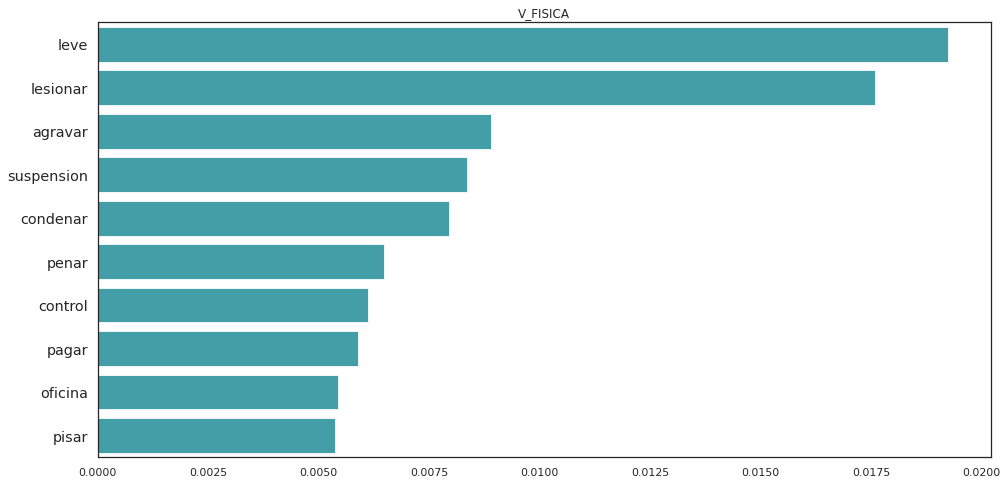

======= Top words for: V_PSIC
incumplimiento 0.03913038711637931
pagar 0.029396084801437773
asistencia 0.025542909691376216
reglar 0.022426182450746887
dano 0.020745356517816272
mes 0.020598425245014484
peso 0.017376064049413074
concepto 0.0160310083417248
efecto 0.014814096589726263
constancia 0.01400206263467291


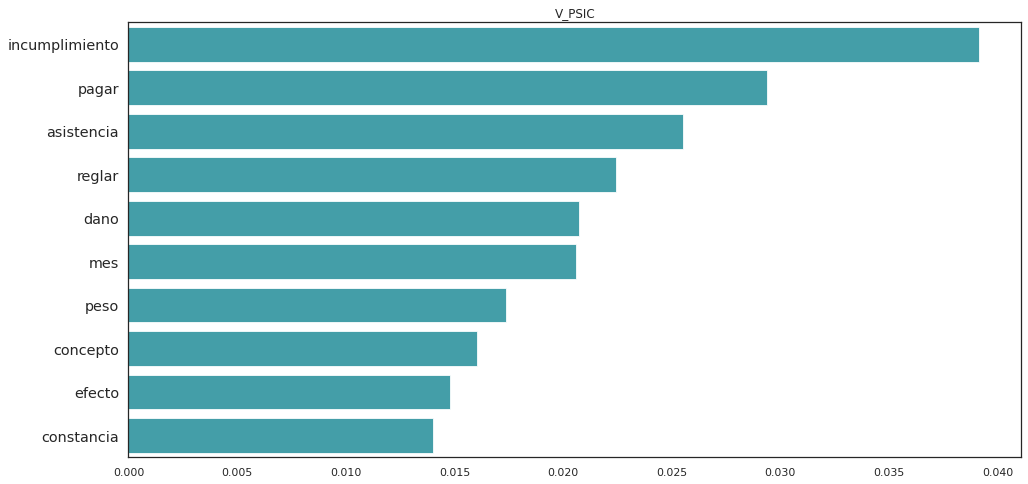

======= Top words for: V_ECON
asistencia 0.017856069774045313
pagar 0.0167529948077807
peso 0.013261724856333786
sumo 0.011476642666978258
mes 0.011073669288491222
multar 0.010261740599329805
familiar 0.009406721591707029
incumplimiento 0.007218583312043655
hora 0.006742339113412089
reparacion 0.006544156331802461


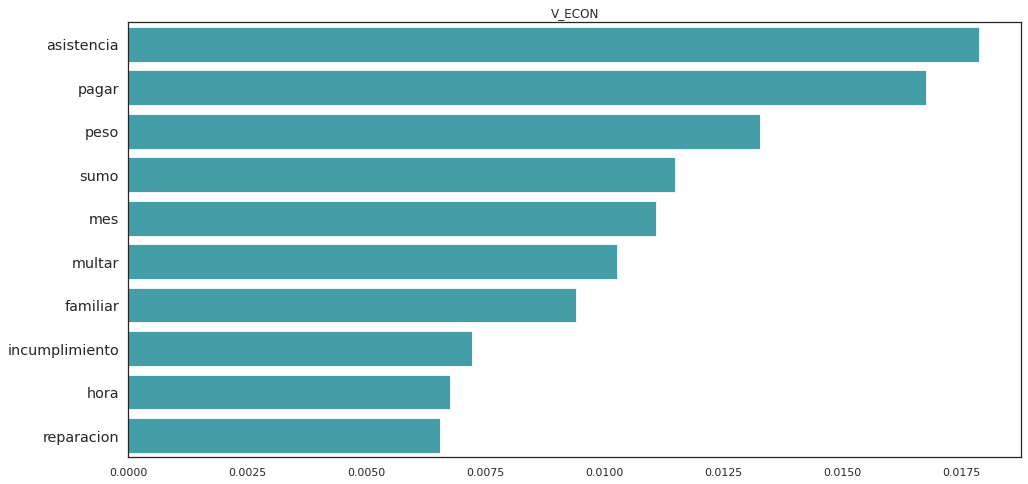

======= Top words for: V_SEX
jurisdiccional 0.014344152478114804
presuntamente 0.013428751865548838
cincar 0.010239617384058682
veinte 0.009805902567991416
avanzar 0.008442385629036216
designar 0.007469549948439423
justicia 0.007441188481682338
materia 0.007110167702194231
convivencia 0.007051347711863126
acusar 0.006862055882561141


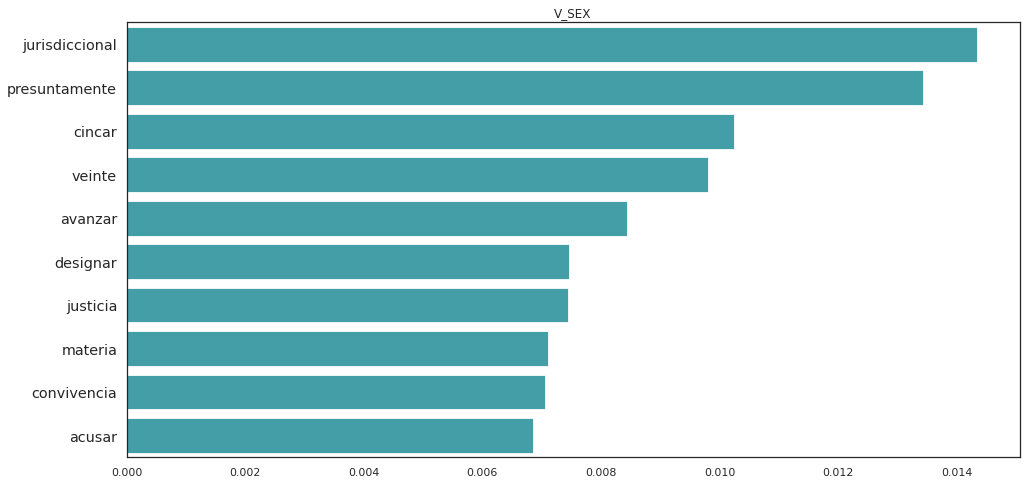

======= Top words for: V_SOC
recordar 0.008585884444311851
acusar 0.007761285840870776
testimonial 0.007065802693374605
agregar 0.00678251849921522
distinto 0.006396129238327736
desear 0.0059581807089779
finar 0.005880622466810871
semana 0.005438248097257236
lesionar 0.005174630260379061
incumplimiento 0.005171380619545316


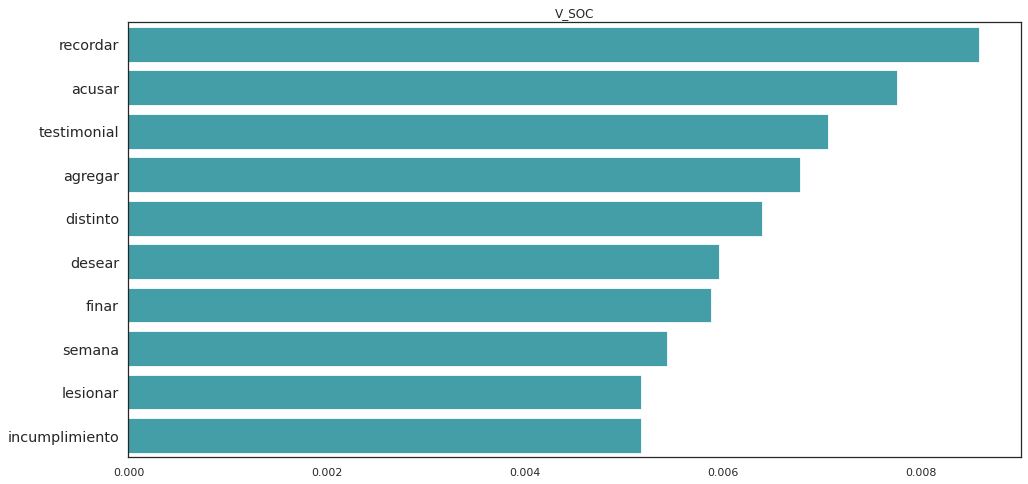

======= Top words for: V_AMB
autonomia 0.01053041290224832
local 0.008369924798579346
ccaba 0.007932068299765057
celebracion 0.007478788822841984
considerar 0.006896494468973081
justicia 0.006479354905088644
respectar 0.006306176749826091
competencia 0.00600818948862434
cppcaba 0.005938885786856885
existir 0.005822199139635788


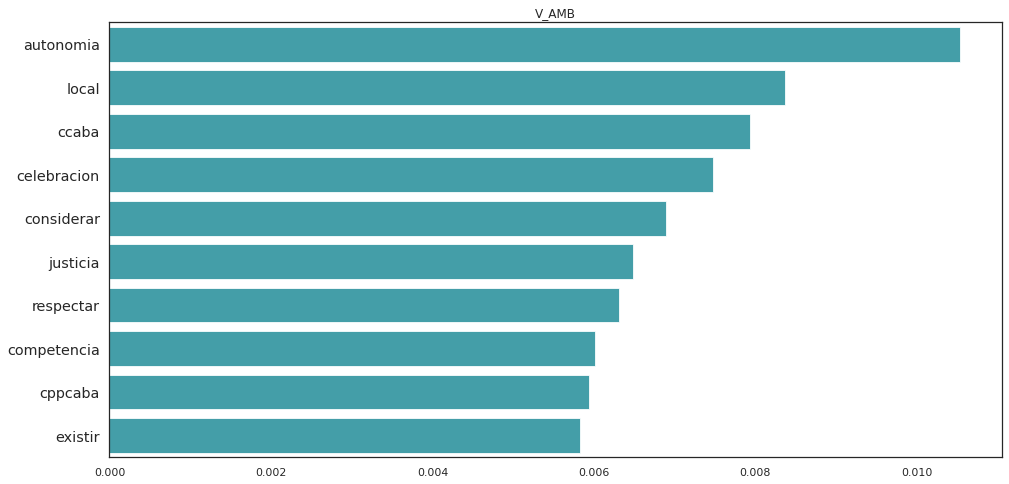

======= Top words for: V_SIMB
pagar 0.08973828638679848
tutelar 0.02573025870390288
reparacion 0.02467990078695886
tomar 0.015209264531356079
procesoprueba 0.015127889144229006
amenazar 0.014767627266880768
familiar 0.014331635818175568
habria 0.013811324228133495
incumplimiento 0.013115010998350319
asimismo 0.011087562350244468


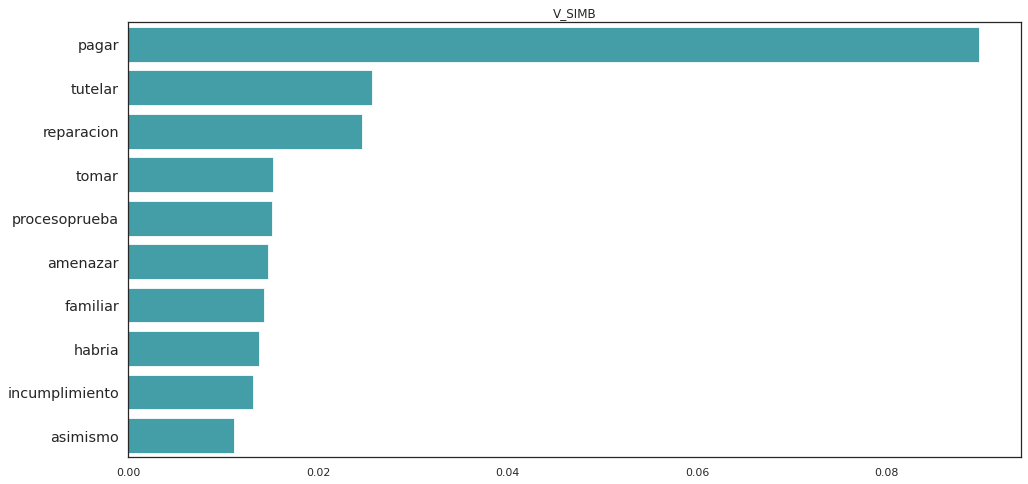

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

target_vars = ["V_FISICA", "V_PSIC", "V_ECON", "V_SEX", 
               "V_SOC", "V_AMB", "V_SIMB"]
K = 10
for var in target_vars:
    print("======= Top words for: %s" % var)
    model = violence_type_model[var]['fitted_model'].best_estimator_
    top = np.flip(np.argsort(model.feature_importances_))[:K]
    top_words = [text_transformer[1].get_feature_names()[i] for i in top]
    top_coef = np.flip(np.sort(model.feature_importances_))[:K]

    for word, coef in zip(top_words,top_coef):
        print(word, coef)
        
    plt.figure(figsize=(16, 8))
    sns.set(style='white')
    sns.barplot(top_coef, top_words, color='#0097a7', alpha=0.8)
    plt.title(var)
    plt.yticks(fontsize='large')
    plt.show()